In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Helper function to display an image with an optional label
def imshow(img, text=None):
    # Convert the image tensor to a NumPy array for plotting
    npimg = img.numpy()
    # Turn off the axis to focus on the image itself
    plt.axis("off")
    # If a label is provided, display it on the image
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    # Display the image; note that the channel order is rearranged
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # Render the plot
    plt.show()

# Helper function to plot the loss over iterations
def show_plot(iteration, loss):
    # Create a plot of the loss against iterations
    plt.plot(iteration, loss)
    # Display the plot
    plt.show()


In [3]:
# Custom dataset class for Siamese Network
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        """
        Args:
            imageFolderDataset: A dataset with images and corresponding labels.
            transform: Optional transform to be applied on a sample.
        """
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: Index of the sample to retrieve.
        Returns:
            A tuple (image1, image2, label):
                - image1: First image in the pair.
                - image2: Second image in the pair.
                - label: 0 if images are from the same class, 1 if different.
        """
        # Randomly select the first image and its label
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        # Randomly decide if the pair should have the same or different class
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            # Find another image with the same class label
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            # Find an image with a different class label
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        # Load images from the file paths
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        # Convert images to grayscale
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply transformations if specified
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # Label: 0 if same class, 1 if different class
        label = torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

        return img0, img1, label

    def __len__(self):
        """
        Returns:
            The total number of image pairs that can be generated.
        """
        return len(self.imageFolderDataset.imgs)


Download the dataset from our [GitHub](https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip) profile, just by running the code below.

In [4]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2024-07-30 02:02:47--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2024-07-30 02:02:48--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip’

at&t.zip            100%[===================>]   3.62M  --.-KB/s    in 0.07s   

2024-07-30 02:02:48 (51.9 MB/s) - ‘at&t.zip’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   creating: .

In [5]:
# Import necessary libraries
from torchvision import datasets, transforms

# Load the training dataset using ImageFolder
# The dataset should be organized such that each subdirectory represents a class
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

# Define a series of transformations to be applied to the images
# - Resize the images to 100x100 pixels
# - Convert the images to PyTorch tensors
transformation = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Initialize the custom dataset for the Siamese network
# - `imageFolderDataset`: The loaded dataset with images and labels
# - `transform`: The transformations to be applied to the images
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)


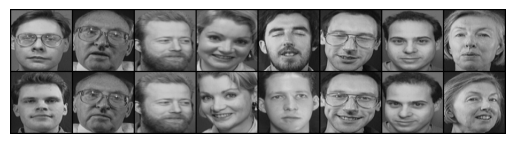

[1. 0. 0. 0. 1. 0. 0. 0.]


In [6]:
# Import necessary libraries
from torch.utils.data import DataLoader
import torchvision
import torch

# Create a DataLoader for the Siamese dataset
# - `siamese_dataset`: The dataset containing image pairs
# - `shuffle=True`: Shuffle the data at each epoch to provide more varied batches
# - `num_workers=2`: Number of subprocesses to use for data loading
# - `batch_size=8`: Number of samples per batch to load
vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            num_workers=2,
                            batch_size=8)

# Extract one batch of data from the DataLoader
example_batch = next(iter(vis_dataloader))

# example_batch is a tuple containing:
# - example_batch[0]: Batch of first images (8 images)
# - example_batch[1]: Batch of second images (8 images)
# - example_batch[2]: Labels indicating if the image pairs are from the same class (0) or different classes (1)
# Concatenate the images in the batch for visualization purposes
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)

# Visualize the concatenated image batch using the imshow helper function
# The torchvision.utils.make_grid function creates a grid of images
imshow(torchvision.utils.make_grid(concatenated))

# Print the labels of the image pairs
# If the label is 1, the images are from different classes (not the same person)
# If the label is 0, the images are from the same class (same person)
print(example_batch[2].numpy().reshape(-1))


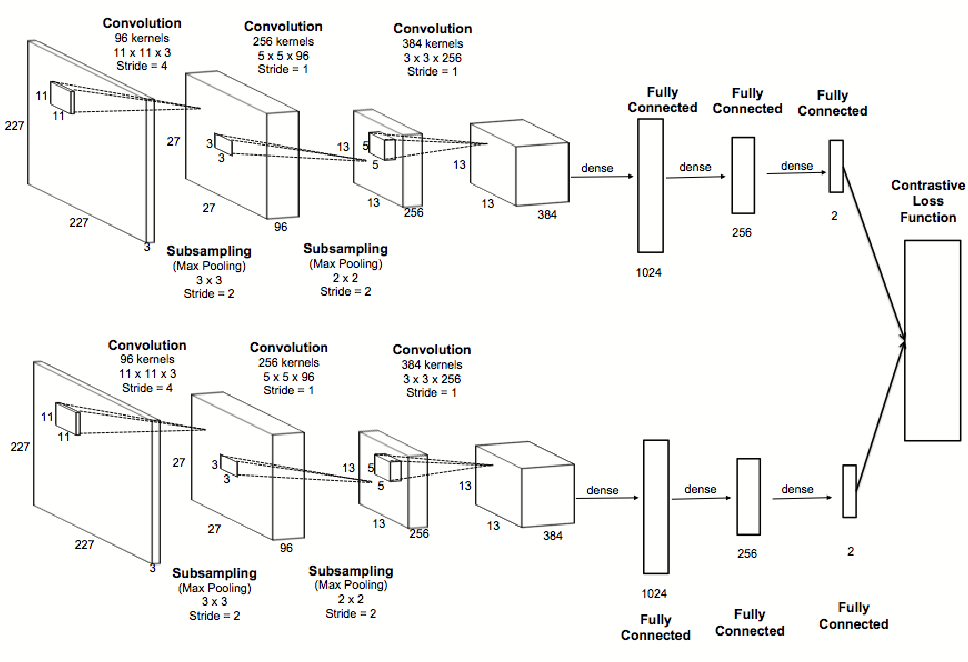

In [7]:
import torch.nn as nn

# Define the Siamese Network architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Convolutional Neural Network layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),  # First convolutional layer
            nn.ReLU(inplace=True),                      # Activation function
            nn.MaxPool2d(3, stride=2),                  # Max pooling layer

            nn.Conv2d(96, 256, kernel_size=5, stride=1), # Second convolutional layer
            nn.ReLU(inplace=True),                      # Activation function
            nn.MaxPool2d(2, stride=2),                  # Max pooling layer

            nn.Conv2d(256, 384, kernel_size=3, stride=1), # Third convolutional layer
            nn.ReLU(inplace=True)                       # Activation function
        )

        # Setting up the Fully Connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),  # First fully connected layer
            nn.ReLU(inplace=True), # Activation function

            nn.Linear(1024, 256),  # Second fully connected layer
            nn.ReLU(inplace=True), # Activation function

            nn.Linear(256, 2)      # Output layer with 2 units (for the output vector)
        )

    def forward_once(self, x):
        """
        This function performs a forward pass through the CNN and fully connected layers
        for one of the input images.
        Args:
            x: The input image tensor.
        Returns:
            The output feature vector for the image.
        """
        output = self.cnn1(x)                 # Pass through CNN layers
        output = output.view(output.size()[0], -1)  # Flatten the output
        output = self.fc1(output)             # Pass through fully connected layers
        return output

    def forward(self, input1, input2):
        """
        This function performs a forward pass through the network for both input images.
        Args:
            input1: The first input image tensor.
            input2: The second input image tensor.
        Returns:
            Two output vectors representing the features of each input image.
        """
        output1 = self.forward_once(input1)  # Forward pass for the first image
        output2 = self.forward_once(input2)  # Forward pass for the second image

        return output1, output2


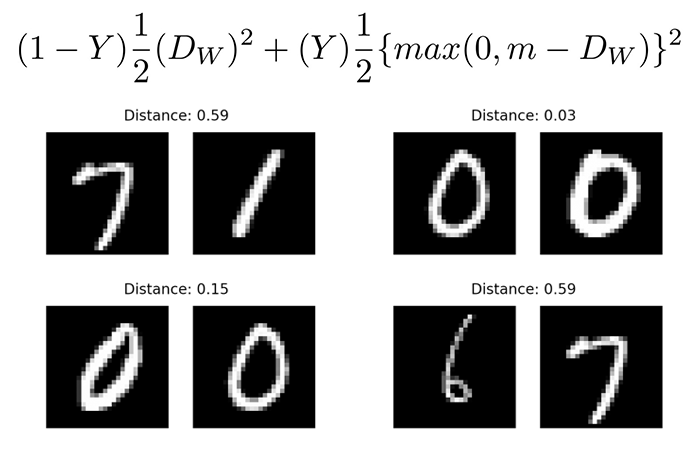

In [8]:
import torch
import torch.nn.functional as F

# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        """
        Initializes the contrastive loss function.
        Args:
            margin: The margin for dissimilar pairs. This margin determines the minimum distance that dissimilar pairs should be apart.
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """
        Forward pass of the contrastive loss function.
        Args:
            output1: The output vector from the Siamese network for the first image.
            output2: The output vector from the Siamese network for the second image.
            label: Binary label indicating whether the pair is similar (0) or dissimilar (1).
        Returns:
            The computed contrastive loss value.
        """
        # Calculate the Euclidean distance between the two output vectors
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)

        # Compute the contrastive loss
        # - For similar pairs (label = 0), the loss encourages the distance to be small.
        # - For dissimilar pairs (label = 1), the loss encourages the distance to be at least the margin value.
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +  # Loss for similar pairs
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)  # Loss for dissimilar pairs
        )

        return loss_contrastive


In [9]:
from torch.utils.data import DataLoader

# Load the training dataset into a DataLoader
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              num_workers=8,
                              batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# Initialize the Siamese Network and move it to the GPU
net = SiameseNetwork().cuda()

# Initialize the Contrastive Loss function
criterion = ContrastiveLoss()

# Initialize the Adam optimizer with the network parameters and a learning rate
optimizer = optim.Adam(net.parameters(), lr=0.0005)

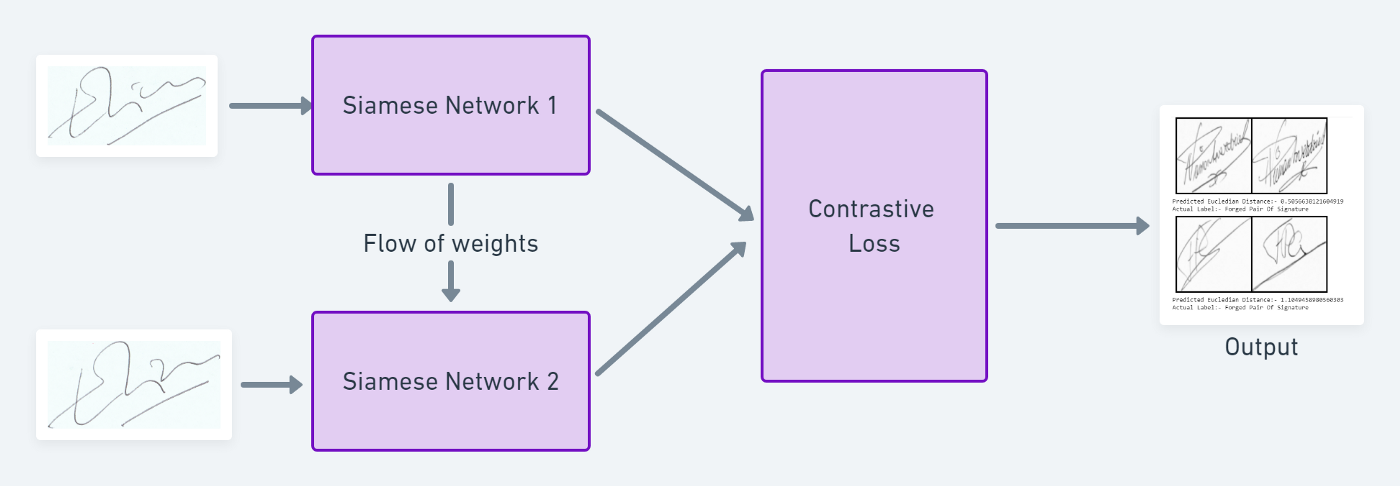

Epoch number 0
 Current loss 1.9358398914337158

Epoch number 1
 Current loss 1.281264305114746

Epoch number 2
 Current loss 0.8526157140731812

Epoch number 3
 Current loss 0.6273687481880188

Epoch number 4
 Current loss 0.5231224298477173

Epoch number 5
 Current loss 0.6118597984313965

Epoch number 6
 Current loss 0.5404462814331055

Epoch number 7
 Current loss 0.6180778741836548

Epoch number 8
 Current loss 0.3828601837158203

Epoch number 9
 Current loss 0.399845153093338

Epoch number 10
 Current loss 0.6786466240882874

Epoch number 11
 Current loss 0.4709285795688629

Epoch number 12
 Current loss 0.31919097900390625

Epoch number 13
 Current loss 0.34567099809646606

Epoch number 14
 Current loss 0.3562798500061035

Epoch number 15
 Current loss 0.45268118381500244

Epoch number 16
 Current loss 0.3090096712112427

Epoch number 17
 Current loss 0.26645195484161377

Epoch number 18
 Current loss 0.44144320487976074

Epoch number 19
 Current loss 0.3776105046272278

Epoch n

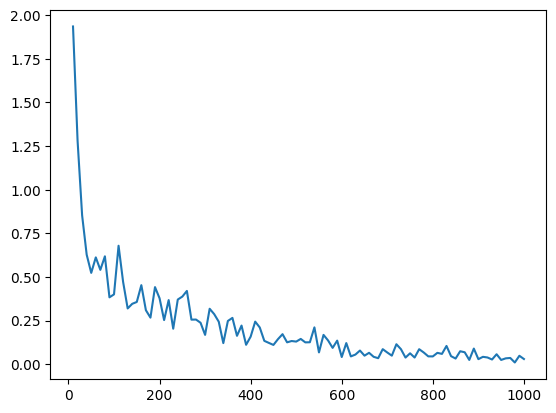

In [11]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

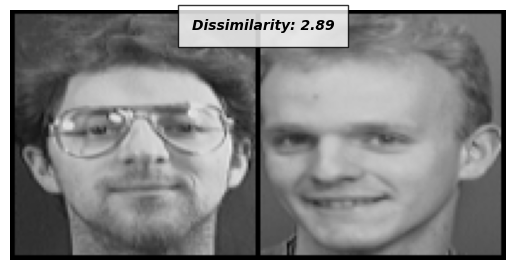

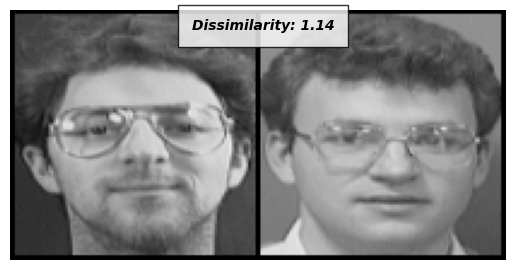

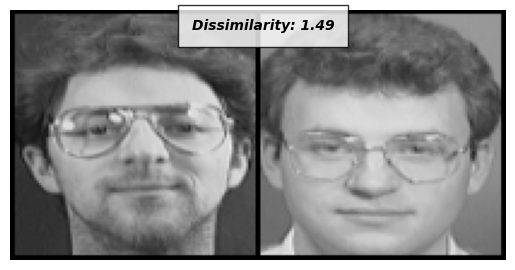

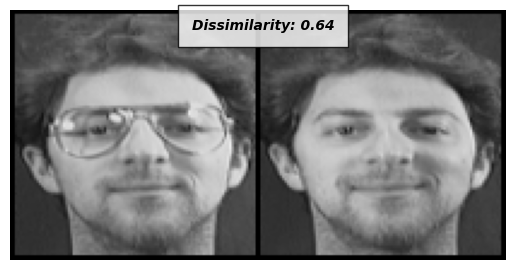

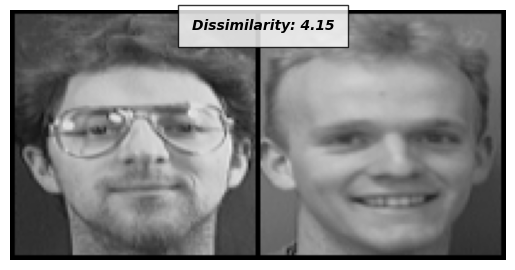

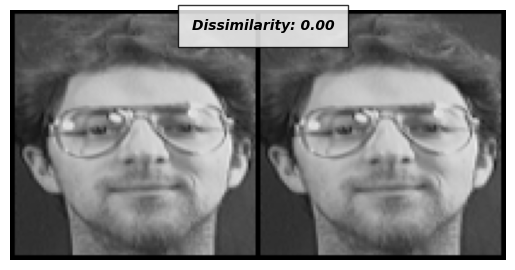

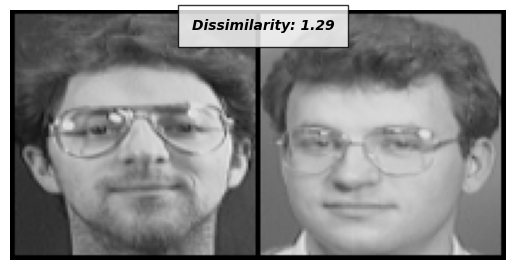

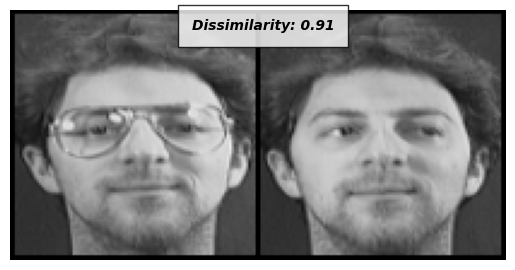

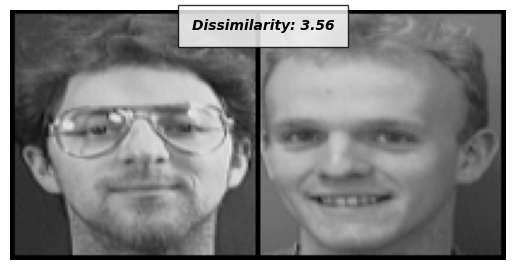

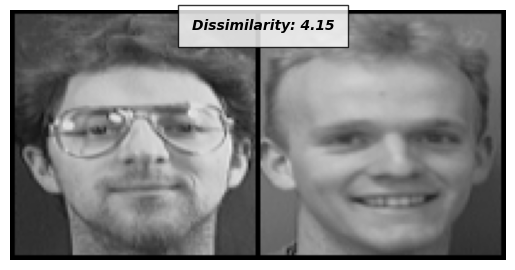

In [12]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')